# Combine ERA5 dataset

### 1. Imports

In [88]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd

#niceties
from rich import print

# Needed
from ipywidgets import IntProgress
from IPython.display import display
from scipy.stats import qmc
import yaml

In [62]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

### 2. Load the datasets

In [63]:
# Load 1990 - 1994
forcing_path_ERA5_90_94 = Path.home() / "forcing" / "loire_river" / "ERA5-90-94" / "work" / "diagnostic" / "script"
ERA5_forcing_9094 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=forcing_path_ERA5_90_94)

# Load 1995 - 2004
forcing_path_ERA5_95_04 = Path.home() / "forcing" / "loire_river" / "ERA5-95-04" / "work" / "diagnostic" / "script" 
ERA5_forcing_9504 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=forcing_path_ERA5_95_04)

# Load 2005 - 2012
forcing_path_ERA5_05_12 = Path.home() / "forcing" / "loire_river" / "ERA5-5-12" / "work" / "diagnostic" / "script"
ERA5_forcing_0512 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=forcing_path_ERA5_05_12)

#Load 2013 - 2019
forcing_path_ERA5_13_19 = Path.home() / "forcing" / "loire_river" / "ERA5-13-19" / "work" / "diagnostic" / "script"
ERA5_forcing_1319 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=forcing_path_ERA5_13_19)

### 3. Merge the data

In [79]:
# List of periods and corresponding filenames
folders = [
    "ERA5-90-94",
    "ERA5-95-04",
    "ERA5-5-12",
    "ERA5-13-19"
]

periods = [
    "1990-1994",
    "1995-2004",
    "2005-2012",
    "2013-2019"
]

# Combine function
def combine_variable(var_name, file):
    datasets = []
    for i, period in enumerate(periods):
        if var_name == 'evspsblpot':
            file_path = Path.home() / "forcing" / "loire_river" / folders[i] / "work" / "diagnostic" / "script" / file
        else:    
            file_name = 'OBS6_ERA5_reanaly_1_day_'+var_name+'_'+period+".nc"
            file_path = Path.home() / "forcing" / "loire_river" / folders[i] / "work" / "diagnostic" / "script" / file_name
        datasets.append(xr.open_dataset(file_path))
    
    combined = xr.concat(datasets, dim='time')
    return combined

### 4. Save the data

In [28]:
# Combine each variable
combined_pr = combine_variable('pr', '_')
combined_tas = combine_variable('tas', '_')
combined_rsds = combine_variable('rsds', '_')
combined_evspsblpot = combine_variable('evspsblpot', 'Derived_Makkink_evspsblpot.nc')

# Save combined datasets
output_path = Path.home() / "forcing" / "loire_river" / "ERA5-90-19"
output_path.mkdir(parents=True, exist_ok=True)

combined_pr.to_netcdf(output_path / "combined_ERA5_1990_2019_pr.nc")
combined_tas.to_netcdf(output_path / "combined_ERA5_1990_2019_tas.nc")
combined_rsds.to_netcdf(output_path / "combined_ERA5_1990_2019_rsds.nc")
combined_evspsblpot.to_netcdf(output_path / "combined_ERA5_1990_2019_evspsblpot.nc")

### 5. Create new yaml file 

In [89]:
# Create yaml 
forcing_yaml = {
    'start_time': '1990-01-01T00:00:00Z',
    'end_time': '2019-12-31T23:59:59Z',
    'shape': 'estreams_cb_FR003882.shp',
    'filenames': {
        'pr': 'combined_ERA5_1990_2019_pr.nc',
        'tas': 'combined_ERA5_1990_2019_tas.nc',
        'rsds': 'combined_ERA5_1990_2019_rsds.nc',
        'evspsblpot': 'combined_ERA5_1990_2019_evspsblpot.nc'
    }
}

# Save the YAML file
yaml_file_path = output_path / "ewatercycle_forcing.yaml"
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(forcing_yaml, yaml_file, default_flow_style=False)

### 6. Check if it works

In [90]:
forcing_combined = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=output_path)

In [91]:
print(forcing_combined)

LumpedMakkinkForcing(
    start_time='1990-01-01T00:00:00Z',
    end_time='2019-12-31T23:59:59Z',
    directory=PosixPath('/home/ischa/forcing/loire_river/ERA5-90-19'),
    shape=PosixPath('/home/ischa/forcing/loire_river/ERA5-90-19/estreams_cb_FR003882.shp'),
    filenames={
        'evspsblpot': 'combined_ERA5_1990_2019_evspsblpot.nc',
        'pr': 'combined_ERA5_1990_2019_pr.nc',
        'rsds': 'combined_ERA5_1990_2019_rsds.nc',
        'tas': 'combined_ERA5_1990_2019_tas.nc'
    }
)

### 7. Test the data

In [92]:
# Give parameters
par_60 = [
    1.5145354171276855,
    0.42842089838706643,
    772.4812259147196,
    1.9621351322761909,
    0.032399644038749675,
    3.6033293703388503,
    0.05641243079972418,
    0.00877512417479108,
    0.20124202520262505
]

# Give initial storages
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0, 150, 0, 15, 0])

# Give a path for model output
model_path_HBV = Path.home() / "tmp" / "HBV_model"

In [93]:
model = ewatercycle.models.HBV(forcing=forcing_combined)
config_file, _ = model.setup(
    parameters=par_60, 
    initial_storage=s_0,
    cfg_dir = model_path_HBV,
)

In [94]:
model.initialize(config_file)

In [95]:
# Run the model
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

# Stop the model
model.finalize()

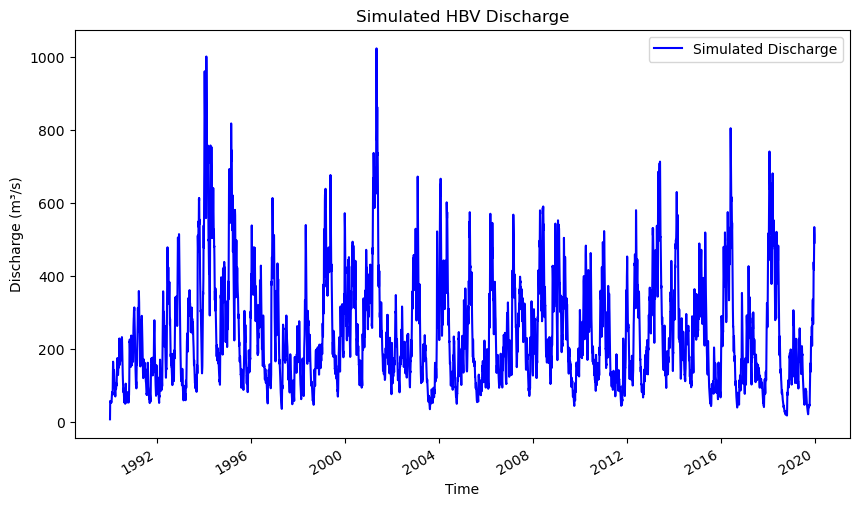

In [96]:
# convert model_output from mm/day to m3/s
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

def convert_Qsim_mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

Q_sim = convert_Qsim_mmday_to_m3s(model_output.values, 38343.99370738107)
Q_sim_pd = pd.Series(Q_sim, index=model_output.index, name="Simulated Discharge")

# plot
plt.figure(figsize=(10, 6))
Q_sim_pd.plot(label="Simulated Discharge", color='blue')
plt.title('Simulated HBV Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
#plt.ylim([20, 75])
plt.legend()
plt.show()